In [1]:
import os
import sys
from importlib import reload
sys.path.append('../src')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from tqdm import tqdm_notebook
from tqdm import tqdm_pandas

## Study the toxicity label diversity

In [2]:
train = pd.read_csv('../input/jigsaw-toxic-comment-train.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

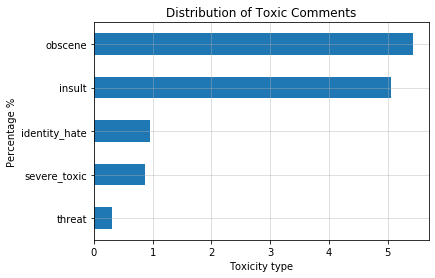

In [5]:
toxic_types_tr = ['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
toxic_types_tr.sort()
fig, ax = plt.subplots(facecolor='white')
(train[toxic_types_tr].sum()/len(train)*100).sort_values().plot(kind='barh', ax=ax)
plt.grid(alpha=0.5)
plt.ylabel('Percentage %')
plt.xlabel('Toxicity type')
plt.title('Distribution of Toxic Comments')
plt.show()

In [6]:
train_ub = pd.read_csv('../input/jigsaw-unintended-bias-train.csv')

In [7]:
train_ub.head()

,id,comment_text,toxic,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,Is this something I'll be able to install on m...,0.000000,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,haha you guys are a bunch of losers.,0.893617,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [8]:
train_ub.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [9]:
train_ub[['toxic', 'rating']].head() # check what is the relevance of toxic and rating
train_ub[['toxic', 'funny', 'wow','sad', 'likes', 'disagree']].groupby('toxic').sum().query('likes')

/opt/anaconda3/envs/basenv/lib/python3.7/site-packages/pandas/core/frame.py:3091: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_data = self.loc[res]


,funny,wow,sad,likes,disagree
toxic,,,,,
3124051,NaN,NaN,NaN,NaN,NaN
0,372451.0,55643.0,135528.0,3124051.0,718397.0
3,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
0,372451.0,55643.0,135528.0,3124051.0,718397.0
19,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
0,372451.0,55643.0,135528.0,3124051.0,718397.0
0,372451.0,55643.0,135528.0,3124051.0,718397.0


In [10]:
train_ub_columns = np.array(train_ub.columns)
train_ub_columns[train_ub_columns == 'identity_attack'] = 'identity_hate'
train_ub_columns[train_ub_columns == 'severe_toxicity'] = 'severe_toxic'
train_ub.columns = train_ub_columns

In [11]:
train_ub.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene',
       'identity_hate', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [12]:
toxic_types_tr_ub = ['severe_toxic', 'obscene',
       'identity_hate', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'sexual_explicit']
toxic_types_tr_ub.sort()

common_cols = []
for col in toxic_types_tr_ub:
    if col in toxic_types_tr:
        common_cols.append(col)
common_cols

['identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat']

In [13]:
train_ub.fillna(0, inplace=True)

In [14]:
train_ub[toxic_types_tr_ub].describe()

,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,...,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,severe_toxic,sexual_explicit,threat,transgender,white
count,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,...,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06,1.902194e+06
mean,2.670463e-03,7.542868e-04,4.254539e-04,7.695698e-03,3.145952e-04,2.136588e-02,2.852046e-02,7.261410e-04,3.265543e-04,5.716064e-03,...,1.838991e-03,1.511147e-03,3.338906e-04,3.031892e-04,2.703897e-03,4.585531e-03,6.595598e-03,9.298498e-03,1.504951e-03,1.270321e-02
std,4.146352e-02,2.450204e-02,1.246211e-02,8.069403e-02,1.460754e-02,1.279077e-01,1.537992e-01,2.175620e-02,1.462140e-02,6.873625e-02,...,2.044104e-02,1.794784e-02,7.300517e-03,8.283157e-03,4.246779e-02,2.286902e-02,4.525432e-02,4.939469e-02,3.278463e-02,1.047111e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,7.500000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


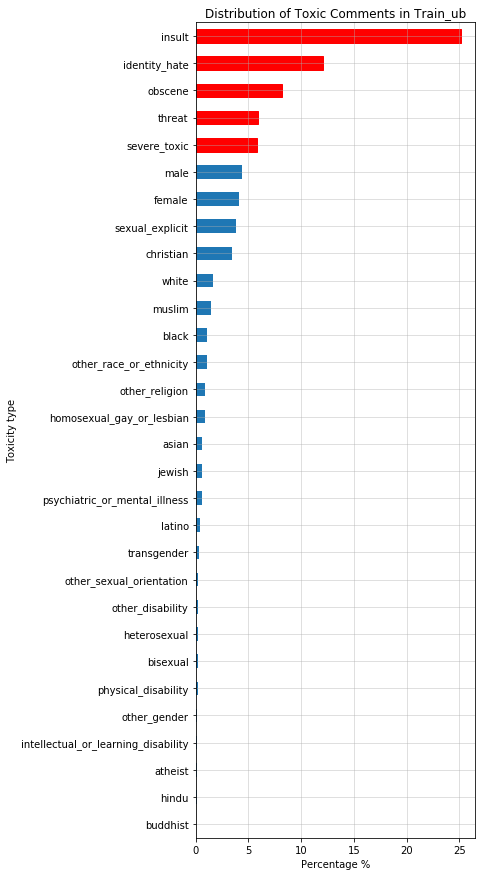

In [15]:
# FIXME: this plot is not accurate as the instances have multiple labels.
fig, ax = plt.subplots(facecolor='white')
df = (train_ub[toxic_types_tr_ub].astype('bool').sum()/len(train_ub)*100).sort_values()
ax = df.plot(kind='barh', figsize=(5,15), ax=ax)
for i, tag in enumerate(df.index):
    if tag in common_cols:
        ax.patches[i].set_color('red')
plt.grid(alpha=0.5)
plt.ylabel('Toxicity type')
plt.xlabel('Percentage %')
plt.title('Distribution of Toxic Comments in Train_ub')
plt.show()

In [16]:
multilabel_instance_count = (train_ub[toxic_types_tr_ub].sum(axis=1) > 1).sum()
print(f"number of multilabel instance: {multilabel_instance_count}")
print(f"total number of instance in the train_ub: {len(train_ub)}")
print(f"percentage of instances with multiple labels: {multilabel_instance_count / len(train_ub) * 100:2.2f}")

number of multilabel instance: 152640
total number of instance in the train_ub: 1902194
percentage of instances with multiple labels: 8.02


/opt/anaconda3/envs/basenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


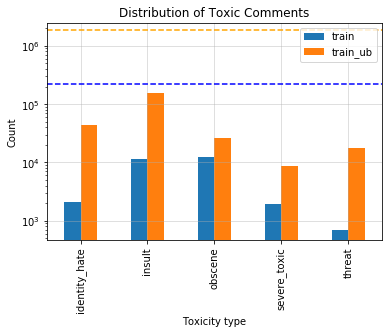

In [17]:
# FIXME: this plot is not accurate as the instances have multiple labels.
fig, ax = plt.subplots(facecolor='white')
toxic_types_counts = pd.DataFrame({'train': train[toxic_types_tr].sum(), 'train_ub': train_ub[common_cols].sum()})
toxic_types_counts.plot(kind='bar', ax=ax)
plt.yscale('log')
plt.grid(alpha=0.5)
plt.ylabel('Count')
plt.xlabel('Toxicity type')
plt.title('Distribution of Toxic Comments')
plt.hlines(len(train), -10, 10, label='train size', color='blue', linestyle='--')
plt.hlines(len(train_ub), -10, 10, label='train_ub size', color='orange', linestyle='--')
plt.ylim([0,2.5e6])
plt.show()

In [18]:
# observations:
# train_ub has different proportion of toxic comments that might influence our generalization on the test set

In [19]:
train_ub_tmp = pd.concat([train_ub, pd.Series(np.ones(len(train_ub)), name='toxic_and_non_toxic')], axis=1)
train_ub_tmp['toxic_binary'] = train_ub_tmp.apply(lambda row: row['toxic'] > 0.5, axis=1) # if toxic is binary yields to same value
for col in toxic_types_tr:
    train_ub_tmp.loc[train_ub_tmp[col] > 0.5, col] = int(1)
    train_ub_tmp.loc[train_ub_tmp[col] <= 0.5, col] = int(0)

In [20]:
train_ub_tmp[toxic_types_tr] = train_ub_tmp[toxic_types_tr].astype(np.uint8)

In [21]:
train_ub_tmp_count = train_ub_tmp.groupby(toxic_types_tr).sum()
train_ub_tmp_count

id  \
identity_hate insult obscene severe_toxic threat                  
0             0      0       0            0       7063213139502   
                                          1          9559677086   
                     1       0            0         13907138685   
                                          1            67966998   
              1      0       0            0        307080696633   
                                          1          1046869296   
                             1            1             5801652   
                     1       0            0         14963778846   
                                          1           180621458   
                             1            0             5883664   
                                          1             5997855   
1             0      0       0            0         22252836465   
                                          1           483677419   
                             1            1             5981279   
                     1       0            0            75066530   
                                          1              779270   
              1      0       0            0          9001459572   
                                          1           121209396   
                             1            1             6088011   
                     1       0            0           828076910   
                                          1            23993431   
                             1            1            11935193   

                                                          toxic        asian  \
identity_hate insult obscene severe_toxic threat                               
0             0      0       0            0       126066.246776  4766.606914   
                                          1         1779.468514     4.066667   
                     1       0            0         2785.217926     6.900000   
                                          1           21.064248     0.000000   
              1      0       0            0        56156.113240   162.868210   
                                          1          221.949318     0.166667   
                             1            1            1.000000     0.000000   
                     1       0            0         3212.267215     9.816667   
                                          1           48.862088     0.600000   
                             1            0            0.900000     0.000000   
                                          1            0.983501     0.000000   
1             0      0       0            0         3570.793172    85.031335   
                                          1           94.847650     0.000000   
                             1            1            0.949045     0.000000   
                     1       0            0           14.360386     0.800000   
                                          1            0.984484     0.000000   
              1      0       0            0         1751.776389    36.779644   
                                          1           25.510664     0.000544   
                             1            1            1.906654     0.000000   
                     1       0            0          176.904735     5.501107   
                                          1            4.898706     0.600000   
                             1            1            1.964332     0.000000   

                                                      atheist    bisexual  \
identity_hate insult obscene severe_toxic threat                            
0             0      0       0            0       1340.533829  756.758659   
                                          1          0.000000    0.000000   
                     1       0            0          0.100000    0.600000   
                                          1          0.000000    0.000000   
              1      0       0            0         50.513244   21.51

In [22]:
train_tmp = pd.concat([train, pd.Series(np.ones(len(train)), name='toxic_and_non_toxic')], axis=1)
train_tmp['toxic_binary'] = train_tmp.apply(lambda row: row['toxic'] > 0.5, axis=1) # if toxic is binary yields to same value
train_tmp_count = train_tmp.groupby(toxic_types_tr).sum()
train_tmp_count

toxic  toxic_and_non_toxic  \
identity_hate insult obscene severe_toxic threat                               
0             0      0       0            0        7376             208457.0   
                                          1         163                190.0   
                             1            0          41                 41.0   
                                          1          11                 11.0   
                     1       0            0        2612               2978.0   
                                          1          17                 19.0   
                             1            0         186                186.0   
                                          1           8                  8.0   
              1      0       0            0        1754               2119.0   
                                          1          25                 29.0   
                             1            0          14                 14.0   
                                          1           1                  1.0   
                     1       0            0        5732               5928.0   
                                          1         196                198.0   
                             1            0        1165               1165.0   
                                          1          88                 88.0   
1             0      0       0            0         203                271.0   
                                          1          11                 11.0   
                             1            0           3                  3.0   
                                          1           5                  5.0   
                     1       0            0          55                 58.0   
                             1            0           7                  7.0   
              1      0       0            0         215                247.0   
                                          1           3                  3.0   
                             1            0           7                  7.0   
                     1       0            0         979                998.0   
                                          1          81                 81.0   
                             1            0         381                381.0   
                                          1          45                 45.0   

                                                  toxic_binary  
identity_hate insult obscene severe_toxic threat                
0             0      0       0            0             7376.0  
                                          1              163.0  
                             1            0               41.0  
                                          1               11.0  
                     1       0            0             2612.0  
                                          1               17.0  
                             1            0              186.0  
                                          1                8.0  
              1      0       0            0             1754.0  
                                          1               25.0  
                             1            0               14.0  
                                          1                1.0  
                     1       0            0             5732.0  
                                          1              196.0  
                             1            0             1165.0  
                                          1               88.0  
1             0      0       0            0              203.0  
                                          1               11.0  
                             1            0                3.0  
                                          1                5.0  
                     1       0            0               55.0  
                             1            0                7.0  
         

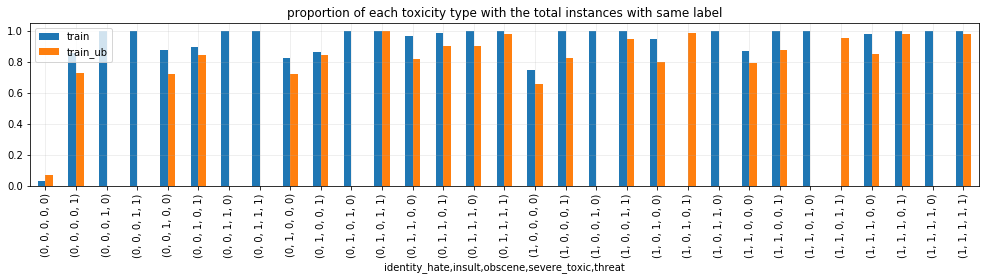

In [23]:
train_prop = (train_tmp_count['toxic'] / train_tmp_count['toxic_and_non_toxic'])
train_ub_prop = (train_ub_tmp_count['toxic'] / train_ub_tmp_count['toxic_and_non_toxic'])
prop_per_toxic_type = pd.DataFrame({'train': train_prop, 'train_ub': train_ub_prop})
#
fig, ax = plt.subplots(facecolor='white', figsize=(17,3))
prop_per_toxic_type.plot(kind='bar', ax=ax)
plt.title('proportion of each toxicity type with the total instances with same label') # that might be classified as toxic/non-toxic
plt.grid(alpha=0.25)
plt.show()
# conclusion: there are some instances that have a toxicity label but were not identified as toxic
# (perhaps their) toxicity was lower than 0.5!

In [24]:
# assert train_ub_tmp_count['toxic'].sum() / train_ub.query('toxic >= 0.5').shape[0] == 1.0

In [25]:
assert train_tmp_count['toxic'].sum() / train.query('toxic >= 0.5').shape[0] == 1.0

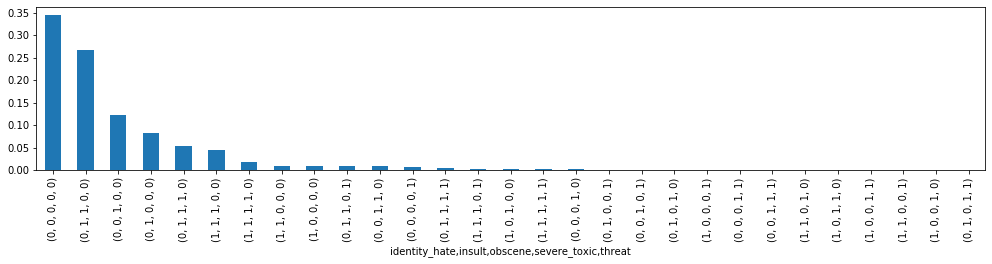

In [26]:
(train_tmp_count['toxic'] / train.query('toxic >= 0.5').shape[0]) \
                                .sort_values(ascending=False).plot(kind='bar', figsize=(17,3))

In [27]:
prop_per_toxic_type

train  train_ub
identity_hate insult obscene severe_toxic threat                    
0             0      0       0            0       0.035384  0.069802
                                          1       0.857895  0.728693
                             1            0       1.000000       NaN
                                          1       1.000000       NaN
                     1       0            0       0.877099  0.722870
                                          1       0.894737  0.842570
                             1            0       1.000000       NaN
                                          1       1.000000       NaN
              1      0       0            0       0.827749  0.723792
                                          1       0.862069  0.843914
                             1            0       1.000000       NaN
                                          1       1.000000  1.000000
                     1       0            0       0.966937  0.821972
                                          1       0.989899  0.904853
                             1            0       1.000000  0.900000
                                          1       1.000000  0.983501
1             0      0       0            0       0.749077  0.658575
                                          1       1.000000  0.824762
                             1            0       1.000000       NaN
                                          1       1.000000  0.949045
                     1       0            0       0.948276  0.797799
                                          1            NaN  0.984484
                             1            0       1.000000       NaN
              1      0       0            0       0.870445  0.791227
                                          1       1.000000  0.879678
                             1            0       1.000000       NaN
                                          1            NaN  0.953327
                     1       0            0       0.980962  0.854612
                                          1       1.000000  0.979741
                             1            0       1.000000       NaN
                                          1       1.000000  0.982166

In [28]:
index_sorted_by_train = []
for i in range(len(train_prop)):
    arr = np.array(train_prop.iloc[i:i+1].index.codes).flatten()
    index_sorted_by_train.append(tuple(arr))
# index_sorted_by_train = np.array(index_sorted_by_train)
index_sorted_by_train

[(0, 0, 0, 0, 0),
 (0, 0, 0, 0, 1),
 (0, 0, 0, 1, 0),
 (0, 0, 0, 1, 1),
 (0, 0, 1, 0, 0),
 (0, 0, 1, 0, 1),
 (0, 0, 1, 1, 0),
 (0, 0, 1, 1, 1),
 (0, 1, 0, 0, 0),
 (0, 1, 0, 0, 1),
 (0, 1, 0, 1, 0),
 (0, 1, 0, 1, 1),
 (0, 1, 1, 0, 0),
 (0, 1, 1, 0, 1),
 (0, 1, 1, 1, 0),
 (0, 1, 1, 1, 1),
 (1, 0, 0, 0, 0),
 (1, 0, 0, 0, 1),
 (1, 0, 0, 1, 0),
 (1, 0, 0, 1, 1),
 (1, 0, 1, 0, 0),
 (1, 0, 1, 1, 0),
 (1, 1, 0, 0, 0),
 (1, 1, 0, 0, 1),
 (1, 1, 0, 1, 0),
 (1, 1, 1, 0, 0),
 (1, 1, 1, 0, 1),
 (1, 1, 1, 1, 0),
 (1, 1, 1, 1, 1)]

In [29]:
train_prop = (train_tmp_count['toxic'] / train.query('toxic >= 0.5').shape[0]).sort_values(ascending=False)
train_ub_prop = (train_ub_tmp_count['toxic'] / train_ub.query('toxic >= 0.5').shape[0]).sort_values(ascending=False)
prop_per_toxic_type = pd.DataFrame({'train': train_prop, 'train_ub': train_ub_prop}).sort_values(by='train', ascending=False)

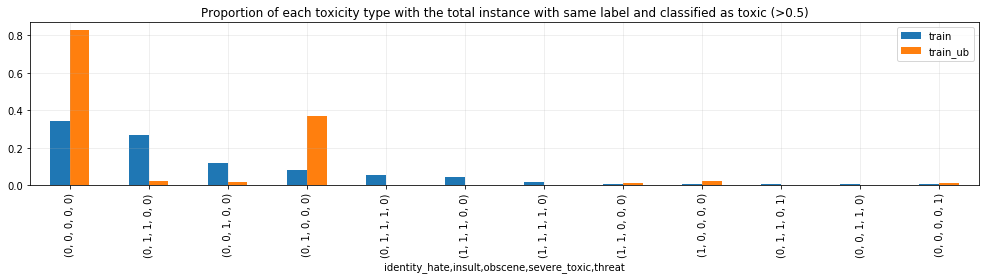

In [30]:
# (train_tmp_count['toxic'] / train.query('toxic >= 0.5').shape[0]) \
#                                 .sort_values(ascending=False).plot(kind='bar', figsize=(17,3))

prop_per_toxic_type[prop_per_toxic_type['train'] > 0.005].plot(kind='bar', figsize=(17,3))
plt.title('Proportion of each toxicity type with the total instance with same label and classified as toxic (>0.5)')
plt.grid(alpha=0.25)
plt.show()

# (train_ub_tmp_count['toxic'] / train_ub.query('toxic >= 0.5').shape[0]).sort_values(ascending=False).plot(kind='bar', figsize=(17,3))

# observation: 
#  ~35% with none of the labels is considered as toxic
#  ~27% with insult and obscene
#  ~12% with severe_toxic
#  ~8% only insult 
#  ~5% insult, obscene and severe_toxic
#  ~5% identity_hate, insult, and obscene

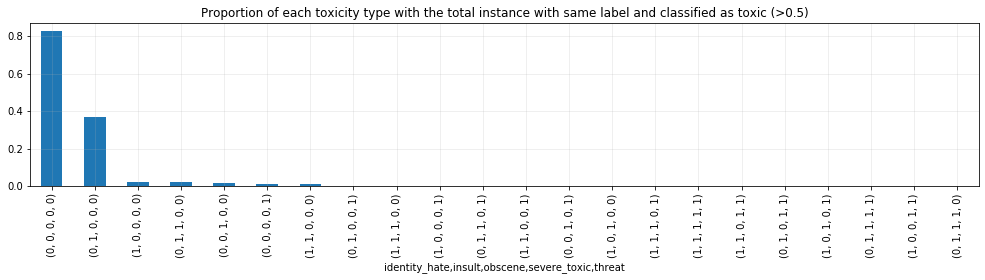

In [31]:
(train_ub_tmp_count['toxic'] / train_ub.query('toxic >= 0.5').shape[0]) \
                                .sort_values(ascending=False).plot(kind='bar', figsize=(17,3))
plt.title('Proportion of each toxicity type with the total instance with same label and classified as toxic (>0.5)')
plt.grid(alpha=0.25)
plt.show()

In [32]:
print(f"number of instance in train:  {len(train):8}")
print(f"number of instance in train_ub: {len(train_ub):7}")

number of instance in train:    223549
number of instance in train_ub: 1902194


## Study the language diversity

In [33]:
from polyglot.detect import Detector
import re

def clean_text(text):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def lang_detector(text):
    text = clean_text(text)
    rslt = Detector("".join(x for x in text if x.isprintable()), quiet=True)
    return rslt.language.code, rslt.language.confidence

In [34]:
langs = train['comment_text'].apply(lang_detector)
langs = pd.DataFrame(list(langs), columns=['lang', 'confidence'])
train = pd.concat([train, langs], axis=1)

In [35]:
langs_ub = train_ub['comment_text'].apply(lang_detector)
langs_ub = pd.DataFrame(list(langs_ub), columns=['lang', 'confidence'])
train_ub = pd.concat([train_ub, langs_ub], axis=1)

In [36]:
def language_count(train_data):
    lang_list = sorted(list(set(train_data["lang"])))
    counts = [list(train_data["lang"]).count(cont) for cont in lang_list]
    df = pd.DataFrame(np.transpose([lang_list, counts]))
    df.columns = ["Language", "Count"]
    df["Count"] = df["Count"].apply(int)
    return df

In [37]:
def english_vs_non_english(df_count):
    df_en = pd.DataFrame({'English: ': df_count.query("Language == 'en'").Count,
                          'non-English': df_count.query("Language != 'en' and Language != 'un'").Count.sum()}, )
    df_en = df_en.T
    df_en.columns = ['Count'] # use a better way to create df_en
    df_en.sort_values(by='Count').plot(kind='barh')
    # plt.xscale('log')
    plt.grid(alpha=0.25)

In [38]:
def other_langs(df_count):
    # fig, axes= plt.subplots(3,1, figsize=(17,10))
    # df_count.query("Language != 'en' and Language != 'un'").query("Count >= 20") \
    #             .set_index('Language').sort_values(by='Count', ascending=False).plot(kind='bar', ax=axes[0])
    # axes[0].grid(alpha=0.2)
    # df_count.query("Language != 'en' and Language != 'un'").query("Count < 20 and Count >= 10") \
    #             .set_index('Language').sort_values(by='Count', ascending=False).plot(kind='bar', ax=axes[1])
    # plt.subplots_adjust(hspace=0.5)
    # axes[1].grid(alpha=0.2)
    # df_count.query("Language != 'en' and Language != 'un'").query("Count < 10") \
    #             .set_index('Language').sort_values(by='Count', ascending=False).plot(kind='bar', ax=axes[2])
    # plt.subplots_adjust(hspace=0.5)
    # axes[2].grid(alpha=0.2)
    # plt.show()

    df_count.query("Language != 'en' and Language != 'un'").query("Count >= 50") \
                .set_index('Language').sort_values(by='Count', ascending=True).iloc[-8:].plot(kind='barh')
    plt.grid(alpha=0.2)

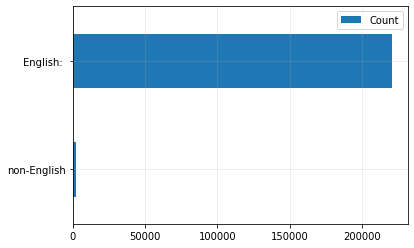

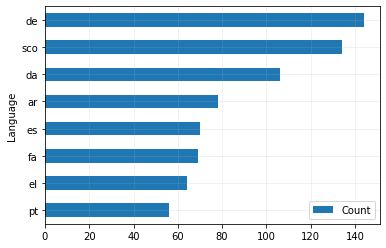

In [39]:
df_count = language_count(train)
english_vs_non_english(df_count)
other_langs(df_count)

In [40]:
# some cleaning might be useful based on unknown language, or language detected but with low confidence ..
# ..(especially when lang code is used as input to the model)
# 
# train.query("lang == 'en' and confidence < 80")
# train_ub.query("lang == 'en' and confidence < 80 and toxic > 0.5")

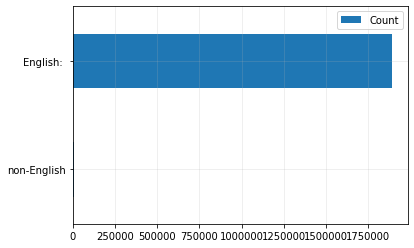

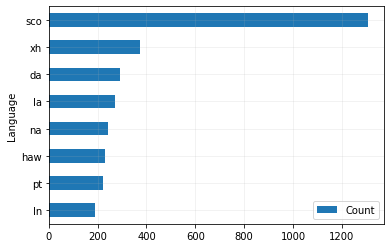

In [41]:
df_count_ub = language_count(train_ub)
english_vs_non_english(df_count_ub)
other_langs(df_count_ub)

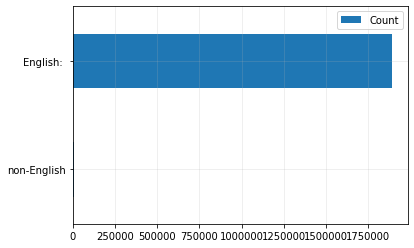

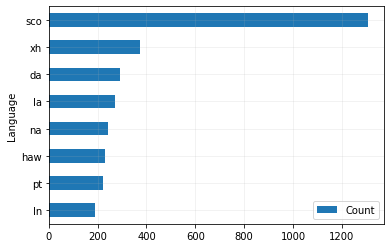

In [42]:
df_count_ub = language_count(train_ub)
english_vs_non_english(df_count_ub)
other_langs(df_count_ub)

In [43]:
df_count.query("Language == 'un'").Count

128    629
Name: Count, dtype: int64

In [44]:
# TODO:
# perhaps better to remove the languages that are unknown or detected with low confidence from the train data
# perhaps it is good to check the language detection output with the lang tag in validation and test..
#  .. to understand any potential discrepencies.

In [45]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,lang,confidence
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,en,99.0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,en,98.0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,en,99.0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,en,99.0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,en,98.0


In [46]:
train_all = pd.concat([
    train[['comment_text', 'toxic']],
    train_ub[['comment_text', 'toxic']].query('toxic==1'),
    train_ub[['comment_text', 'toxic']].query('toxic==0').sample(n=150000, random_state=0)
])

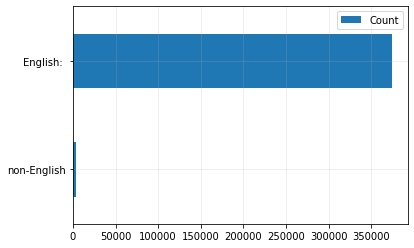

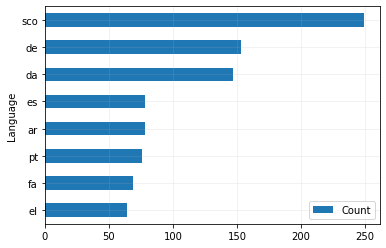

In [47]:
langs = train_all['comment_text'].apply(lang_detector)
langs = pd.DataFrame(list(langs), columns=['lang', 'confidence'])
train_all = pd.concat([train_all.reset_index(drop=True), langs.reset_index(drop=True)], axis=1)
#
df_count = language_count(train_all)
english_vs_non_english(df_count)
other_langs(df_count)

## Study the validation and test 

In [48]:
valid = pd.read_csv('../input/validation.csv', index_col=0)
valid.head()

,comment_text,lang,toxic
id,,,
0,Este usuario ni siquiera llega al rango de ...,es,0
1,Il testo di questa voce pare esser scopiazzato...,it,0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [49]:
test = pd.read_csv('../input/test.csv', index_col=0)
test.head()

,content,lang
id,,
0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,"Quindi tu sei uno di quelli conservativi , ...",it
3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


In [50]:
df_count_va = language_count(valid).set_index('Language')
df_count_te = language_count(test).set_index('Language')

/opt/anaconda3/envs/basenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


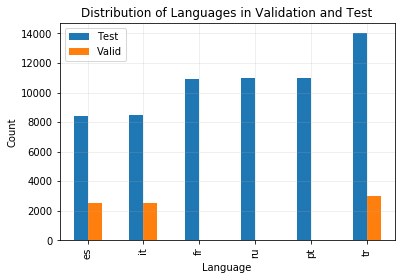

In [51]:
df_count_valid_test = pd.concat([df_count_te, df_count_va], axis=1,)
df_count_valid_test.columns = ['Test', 'Valid']
df_count_valid_test.sort_values(by='Test').plot(kind='bar')
plt.grid(alpha=0.25)
plt.ylabel('Count')
plt.xlabel('Language')
plt.title('Distribution of Languages in Validation and Test')
plt.show()